# Tennis Playing Reinforcement Learning Multi-Agent in 3D-Environment

The following notebook provides a reinforcement learning multi-agent which is trained to play tennis in an episodic Unity 3D-environment. The multi-agent consists of two agents, each equipped with a racket. The multi-agent is trained such that each agent tries to hit the tennis ball with its racket and then hit the floor on the other side of the net.

### 1. Setup

We begin by importing the Python packages required for the project.

Next, we create the 3D-environment containing the tennis court. This environment is based on the Unity engine and is provided by Udacity. The environment contains a brain, which is controlled by the reinforcement learning agent used further below.

In [1]:
import keyboard

import matplotlib.pyplot as plt
import numpy as np

from collections import deque
from unityagents import UnityEnvironment

environment = UnityEnvironment("Tennis_Windows_x86_64\Tennis.exe")

brain_name = environment.brain_names[0]
brain = environment.brains[brain_name]

info = environment.reset(train_mode=True)[brain_name]

number_agents = len(info.vector_observations)
number_sensors = len(info.vector_observations[0])
number_motors = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Training

Now, we come to the training of the reinforcement learning multi-agent. When the next cell is executed, the Unity environment is shown as a small window and the training starts. The progress of the training is shown in form of a continuously updated log message. The training stops when either an averge collective score of 0.5 is reached or the user hits the Escape key. The average collective score is defined as the collective score computed over the most recent 100 episodes. Here, the collective score is the maximum of the individual scores of the two agents, where the individual score of each agent is the non-discounted return, i.e. cumulative reward per episode. When the training is finished, a plot of the collective scores over the episodes is displayed and the neural networks of the reinforcement learning multi-agent are saved.

If you have a GPU which requires at least CUDA 9.0, you might encounter a startup-phase taking several minutes for the next cell, because the PyTorch version 0.4.0 required for this project was compiled with CUDA 8.0. Newer versions of PyTorch were not considered here, because this project was created in the context of a Udacity nanodegree program, where the PyTorch version is fixed. So, if the execution freezes, please be patient for a few minutes.

The next cell also contains a fast development mode. When the training has stopped, you can simple execute the cell another time and a new multi-agent is trained with the most recent state of the Python packages coded for the multi-agent, i.e. including any code changes taken since the last execution, without having to restart the Python kernel and the Unity environment. This development mode also addresses the slow startup-phase mentioned above.

CODE DETAILS:

The code in the cell first creates a new multi-agent, which is provided in external Python scripts, and resets the environment. Then, it lets the multi-agent determine an action in the current state. This action causes a change of the environment which is observed and provides a reward. The reward then allows a learning step of the multi-agent. The steps starting with the action determination are then repeated until an episode is finished. Then, the environment is reset and the next episode starts. The training continues over multiple episodes until the stop criterion mentioned earlier is reached.

Fast development reload: network
Fast development reload: memory
Fast development reload: agent
Used device: cpu

Policy Network - Actor(
  (__linear_0): Linear(in_features=24, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=2, bias=True)
)

Target Policy Network - Target Actor(
  (__linear_0): Linear(in_features=24, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=2, bias=True)
)

Q Network - NonlocalCritic(
  (__linear_0): Linear(in_features=52, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=64, bias=True)
  (__linear_3): Linear(in_features=64, out_features=1, bias=True)
)

Target Q Network - Target NonlocalCritic(
  (__linear_0): Linear(in_features=52, out_features=64, bias=True)
  (__linear

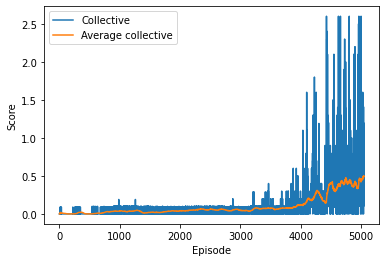

In [10]:
# The nubmer of episodes used to compute the average score.
NUMBER_AVERAGED_EPISODES = 100

# The average collective score where the training stops.
MAX_AVERAGE_COLLECTIVE_SCORE = 0.5

import agent

if agent.network.FAST_DEVELOPMENT_MODE:
    import importlib

    importlib.reload(agent)
    print("Fast development reload: agent")

from agent import Agent

agents = []
for index in range(number_agents):
    agents.append(Agent(number_agents, number_sensors, number_motors, agents, index))

all_collective_scores = []
last_collective_scores = deque(maxlen=NUMBER_AVERAGED_EPISODES)
all_average_collective_scores = []

episode = 0
average_collective_score = 0

reset = True
while True:
    if reset:
        info = environment.reset(train_mode=True)[brain_name]
        observations = info.vector_observations
        individual_scores = np.zeros(number_agents)
        reset = False

    actions = np.array([agents[index](observations[index]) for index in range(number_agents)])
    info = environment.step(actions)[brain_name]
    next_observations = info.vector_observations
    rewards = info.rewards
    dones = info.local_done

    for agent in agents:
        agent.learn(observations, actions, rewards, next_observations, dones)

    individual_scores += rewards
    observations = next_observations

    if True in dones:
        episode += 1

        collective_score = np.max(individual_scores)

        all_collective_scores.append(collective_score)
        last_collective_scores.append(collective_score)

        average_collective_score = np.mean(last_collective_scores)

        all_average_collective_scores.append(average_collective_score)

        reset = True

    epsilon = agents[0].epsilon
    log = f"\rEpisode = {episode}, Epsilon = {epsilon:.2g}, Individual scores = ({individual_scores[0]:.2g}, " \
          f"{individual_scores[1]:.2g}), Average collective score = {average_collective_score:.3g}" + 15 * " "
    print(log, end="", flush=True)

    if keyboard.is_pressed("esc") or (average_collective_score >= MAX_AVERAGE_COLLECTIVE_SCORE):
        print()
        break

for agent in agents:
    agent.save("agent")

plt.plot(all_collective_scores, label="Collective")
plt.plot(all_average_collective_scores, label="Average collective")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend(loc="upper left")
plt.show()

### 3. Inference

Execute the next cell to let the saved reinforcement learning to be used in inference mode. This mode also provides a larger window for the Unity environment than in training mode. The inference ends when a single episode is done or the user hits the Escape key.

In [4]:
import agent

if agent.network.FAST_DEVELOPMENT_MODE:
    import importlib

    importlib.reload(agent)
    print("Fast development reload: agent")

from agent import Agent

agents = []
for index in range(number_agents):
    agents.append(Agent(number_agents, number_sensors, number_motors, agents, index))

for agent in agents:
    agent.load("agent")

info = environment.reset(train_mode=False)[brain_name]

individual_scores = np.zeros(number_agents)

while True:
    observations = info.vector_observations
    actions = np.array([agents[index](observations[index]) for index in range(number_agents)])
    info = environment.step(actions)[brain_name]
    dones = info.local_done

    individual_scores += info.rewards

    if keyboard.is_pressed("esc") or (True in dones):
        break

collective_score = np.max(individual_scores)
print("Collective score =", collective_score)

Fast development reload: network
Fast development reload: memory
Fast development reload: agent
Used device: cpu

Policy Network - Actor(
  (__linear_0): Linear(in_features=24, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=2, bias=True)
)

Target Policy Network - Target Actor(
  (__linear_0): Linear(in_features=24, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=2, bias=True)
)

Q Network - NonlocalCritic(
  (__linear_0): Linear(in_features=52, out_features=64, bias=True)
  (__linear_1): Linear(in_features=64, out_features=64, bias=True)
  (__linear_2): Linear(in_features=64, out_features=64, bias=True)
  (__linear_3): Linear(in_features=64, out_features=1, bias=True)
)

Target Q Network - Target NonlocalCritic(
  (__linear_0): Linear(in_features=52, out_features=64, bias=True)
  (__linear

### 4. Teardown

When you are done with training and inference, you can close the Unity environment with the following cell.

In [5]:
environment.close()